In [28]:
# import statements at the top for readability
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from ISLP.svm import plot as plot_svm
from sklearn import svm
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('nhis_2022.csv')
data.head()

,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,...,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,...,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,...,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,...,996,996,996,996,996,996,996,996,0,2
3,2022,3,134,13,0002022H000006,2,1,0002022H00000610,H000006,2681.0,...,1,1,1,0,2,0,1,1,6,2
4,2022,4,106,53,0002022H000007,3,1,0002022H00000710,H000007,10233.0,...,3,30,5,1,0,30,6,2,8,2


In [3]:
data.columns

Index(['YEAR', 'SERIAL', 'STRATA', 'PSU', 'NHISHID', 'REGION', 'PERNUM',
       'NHISPID', 'HHX', 'SAMPWEIGHT', 'ASTATFLG', 'CSTATFLG', 'AGE', 'SEX',
       'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT', 'WEIGHT',
       'BMICALC', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV', 'DIABETICEV',
       'HEARTATTEV', 'STROKEV', 'ALCANYNO', 'ALCDAYSYR', 'CIGDAYMO',
       'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO', 'HRSLEEP',
       'CVDSHT'],
      dtype='object')

In [4]:
data.shape

(35115, 48)

## Data Preprocessing

In [5]:
# variables i want to use
target = 'CANCEREV'
demo = ['AGE', 'SEX', 'BMICALC', 'EDUC', 'HINOTCOVE'] 
habits = ['HRSLEEP','FRUTNO' ,'VEGENO', 'COFETEAMNO']
data = data[[target] + demo + habits]
data.columns

Index(['CANCEREV', 'AGE', 'SEX', 'BMICALC', 'EDUC', 'HINOTCOVE', 'HRSLEEP',
       'FRUTNO', 'VEGENO', 'COFETEAMNO'],
      dtype='object')

In [6]:
data.isna().sum()
# no missing values. interesting

CANCEREV      0
AGE           0
SEX           0
BMICALC       0
EDUC          0
HINOTCOVE     0
HRSLEEP       0
FRUTNO        0
VEGENO        0
COFETEAMNO    0
dtype: int64

In [7]:
for col in data.columns:
    print(data[col].value_counts())

CANCEREV
1    24184
0     7464
2     3430
7       28
9        9
Name: count, dtype: int64
AGE
85     1002
64      559
67      557
68      555
66      551
       ... 
19      204
83      197
84      188
997      59
999       5
Name: count, Length: 88, dtype: int64
SEX
2    18653
1    16456
9        4
7        2
Name: count, dtype: int64
BMICALC
996.0    6833
25.8      712
26.6      690
25.1      613
24.4      481
         ... 
47.6        1
12.8        1
45.9        1
45.8        1
14.9        1
Name: count, Length: 366, dtype: int64
EDUC
0      7464
201    6351
400    6307
301    4112
501    3025
303    2561
103    1881
505    1080
302    1065
202     632
116     488
999     101
997      48
Name: count, dtype: int64
HINOTCOVE
1    32618
2     2388
9      109
Name: count, dtype: int64
HRSLEEP
7     8370
8     8031
0     7464
6     5444
5     1652
9     1399
98     861
10     657
4      598
12     193
3      113
99      97
11      75
2       41
14      23
13      22
16      18
97      14

In [8]:
# clean/filter the invalid values like 999, 998, etc.
data = data[data['CANCEREV'].isin([1, 2])]
data = data[data['SEX'].isin([1, 2])]
data = data[data['HINOTCOVE'].isin([1, 2])]
data['AGE'] = data['AGE'].replace([999, 998, 997], np.nan)
data['BMICALC'] = data['BMICALC'].replace([996, 0], np.nan)
data['EDUC'] = data['EDUC'].replace([999, 998, 997, 996, 000], np.nan)
data['HRSLEEP'] = data['HRSLEEP'].replace([99, 98, 97, 00], np.nan)
data['FRUTNO'] = data['FRUTNO'].replace([999, 998, 997, 996], np.nan)
data['VEGENO'] = data['VEGENO'].replace([999, 998, 997, 996], np.nan)
data['COFETEAMNO'] = data['COFETEAMNO'].replace([999, 998, 997, 996], np.nan)
data = data.dropna()
data.head()

,CANCEREV,AGE,SEX,BMICALC,EDUC,HINOTCOVE,HRSLEEP,FRUTNO,VEGENO,COFETEAMNO
0,1,61.0,1,38.4,201.0,1,8.0,5.0,15.0,0.0
1,1,43.0,1,27.3,301.0,1,6.0,1.0,1.0,1.0
3,1,68.0,1,25.0,505.0,1,6.0,3.0,1.0,0.0
4,1,73.0,1,24.0,201.0,1,8.0,2.0,4.0,30.0
6,1,73.0,1,26.5,201.0,1,6.0,1.0,2.0,0.0


In [9]:
data.shape

(23943, 10)

In [10]:
for col in data.columns:
    print(data[col].value_counts())

CANCEREV
1    20916
2     3027
Name: count, dtype: int64
AGE
85.0    821
68.0    492
67.0    490
64.0    489
66.0    480
       ... 
18.0    171
20.0    168
19.0    168
83.0    167
84.0    164
Name: count, Length: 68, dtype: int64
SEX
2    12940
1    11003
Name: count, dtype: int64
BMICALC
25.8    632
26.6    619
25.1    540
24.4    425
28.3    400
       ... 
52.7      1
45.8      1
46.8      1
45.4      1
51.7      1
Name: count, Length: 332, dtype: int64
EDUC
400.0    5641
201.0    5414
301.0    3551
501.0    2749
303.0    2251
103.0    1497
505.0     980
302.0     926
202.0     530
116.0     404
Name: count, dtype: int64
HINOTCOVE
1    22207
2     1736
Name: count, dtype: int64
HRSLEEP
7.0     7607
8.0     7206
6.0     4904
5.0     1442
9.0     1246
10.0     573
4.0      522
12.0     166
3.0       94
11.0      69
2.0       34
13.0      20
14.0      18
16.0      11
15.0      10
1.0        7
18.0       5
17.0       3
20.0       3
24.0       1
19.0       1
22.0       1
Name: count, dt

In [11]:
groups = {
    'Demo': (data[demo], data[target]),
    'Habits': (data[habits], data[target])
}

## Modeling - Linear SVM


Running Linear SVM for Demo variables...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Params for Demo: {'C': 1}
Best CV Score for Demo: 0.7059301767085192
              precision    recall  f1-score   support

   No Cancer       0.96      0.63      0.76      4159
      Cancer       0.25      0.83      0.39       630

    accuracy                           0.65      4789
   macro avg       0.61      0.73      0.57      4789
weighted avg       0.87      0.65      0.71      4789



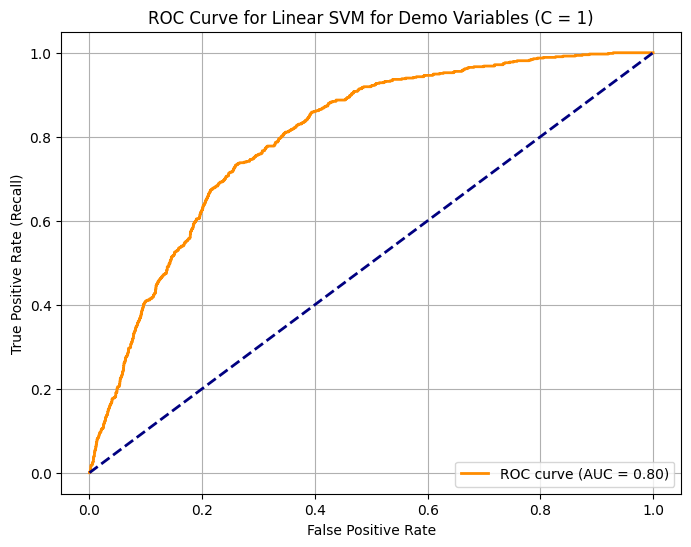


Running Linear SVM for Habits variables...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Params for Habits: {'C': 0.001}
Best CV Score for Habits: 0.7022225188466003
              precision    recall  f1-score   support

   No Cancer       0.87      0.67      0.76      4159
      Cancer       0.14      0.35      0.20       630

    accuracy                           0.63      4789
   macro avg       0.51      0.51      0.48      4789
weighted avg       0.78      0.63      0.69      4789



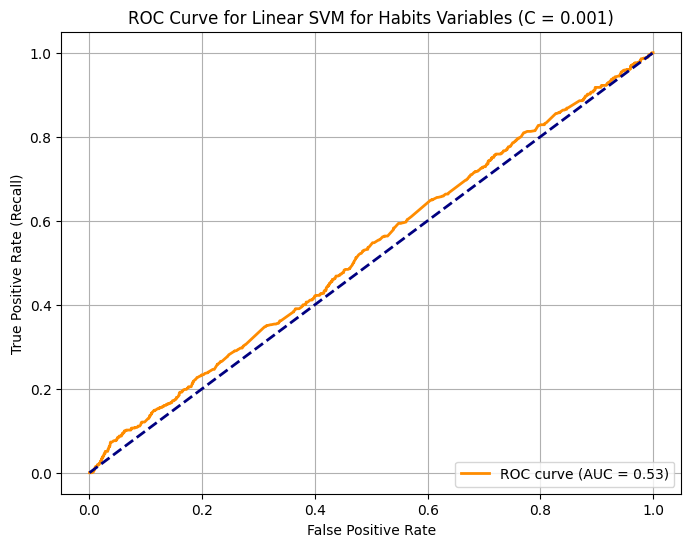

In [ ]:
param_linear = {'C': [0.001, 0.01, 0.1, 1, 10]}
linear = SVC(kernel = 'linear', class_weight = 'balanced', random_state = 5322)

for name, (X, y) in groups.items():
    print(f'\nRunning Linear SVM for {name} variables...')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 5322)
    
    grid_linear = GridSearchCV(
        estimator = linear,
        param_grid = param_linear,
        scoring = 'f1_weighted',
        cv = 3,
        n_jobs = -1,
        verbose = 1 
        # change verbose to 3 to see [CV 3/3] END ............................C=0.01;, score=0.700 total time=  11.5s
        # to check whether the grid search params are reasonable and changing the scores
    )
    
    grid_linear.fit(x_train, y_train)
    
    # get metrics
    print(f"Best Params for {name}: {grid_linear.best_params_}")
    print(f"Best CV Score for {name}: {grid_linear.best_score_}")
    print(classification_report(y_test, grid_linear.predict(x_test), zero_division = 0, target_names = ['No Cancer', 'Cancer']))

    y_scores = grid_linear.decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label = 2)
    roc_auc = auc(fpr, tpr)

    # plot roc curve
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for Linear SVM for {name} Variables (C = {grid_linear.best_params_["C"]})')
    plt.legend(loc = "lower right")
    plt.grid(True)
    plt.show()
    print('=' * 50)

Some things to note:

From the AUCs, demographic variables are more predictive of cancer than habit related ones\
Precision is high for non-cancer individuals, but recall is low\
Precision is low for cancer individuals, but recall is slightly higher\
Clear class imbalance: a lot more non-cancer individuals in our dataset versus cancer individuals

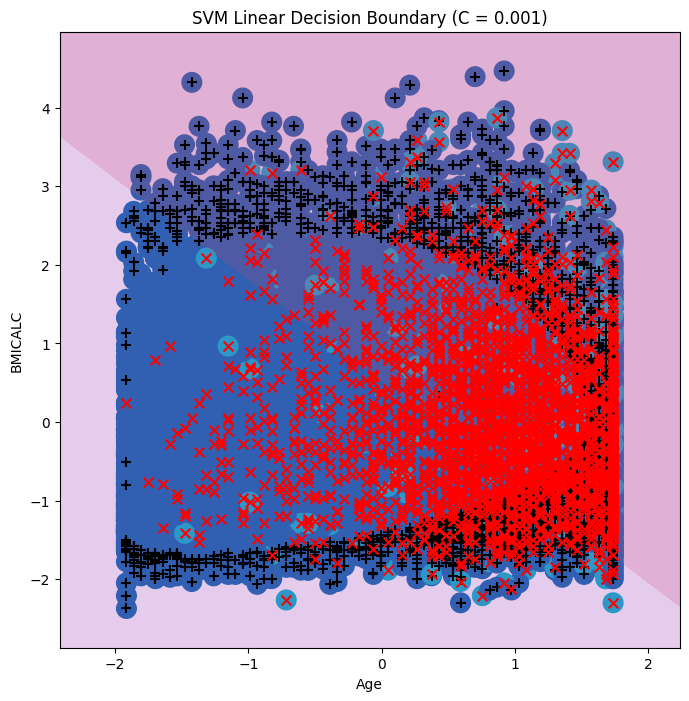

In [13]:
X_plot = data[['AGE', 'BMICALC']].values
y_plot = data[target].values

scaler = StandardScaler()
X_plot = scaler.fit_transform(X_plot)

svm_plot = SVC(C = grid_linear.best_params_['C'], kernel = 'linear', random_state = 5322)
svm_plot.fit(X_plot, y_plot)

fig, ax = subplots(figsize = (8, 8))
plot_svm(X_plot, y_plot, svm_plot, ax = ax)
ax.set_xlabel('Age')
ax.set_ylabel('BMICALC')
ax.set_title(f'SVM Linear Decision Boundary (C = {grid_linear.best_params_["C"]})')
plt.show()

Ehh. Not good but not terrible decision boundary I guess

## Modeling - Radial


Running radial SVM for Demo variables...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for Demo: {'C': 0.1, 'gamma': 100}
Best CV Score for Demo: 0.8272821189601509
              precision    recall  f1-score   support

   No Cancer       0.89      0.90      0.90      4159
      Cancer       0.31      0.29      0.30       630

    accuracy                           0.82      4789
   macro avg       0.60      0.59      0.60      4789
weighted avg       0.82      0.82      0.82      4789



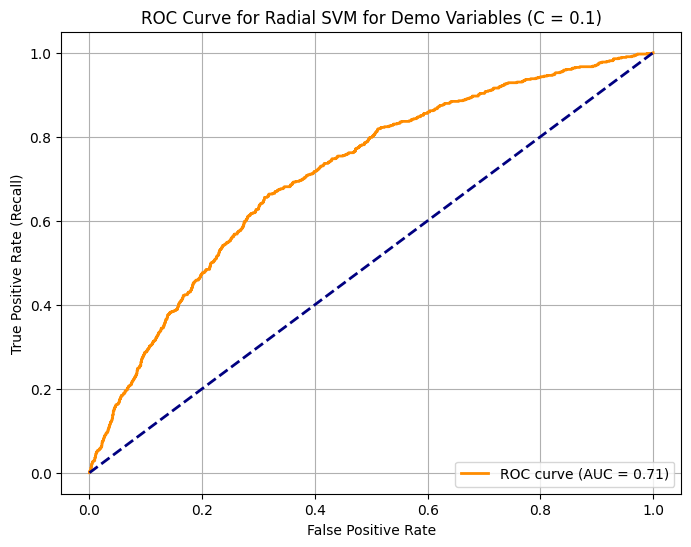


Running radial SVM for Habits variables...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for Habits: {'C': 0.1, 'gamma': 500}
Best CV Score for Habits: 0.7161411492122173
              precision    recall  f1-score   support

   No Cancer       0.88      0.71      0.78      4159
      Cancer       0.15      0.34      0.21       630

    accuracy                           0.66      4789
   macro avg       0.51      0.52      0.50      4789
weighted avg       0.78      0.66      0.71      4789



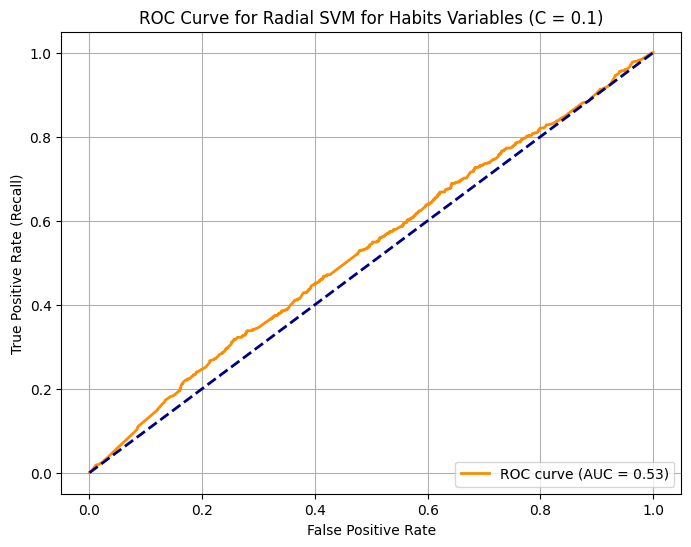

In [ ]:
param_radial = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 1, 10, 100, 500, 1000]
}

radial = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 5322)

for name, (X, y) in groups.items():
    print(f'\nRunning radial SVM for {name} variables...')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 5322)
    
    grid_radial = GridSearchCV(
        estimator = radial,
        param_grid = param_radial,
        scoring = 'f1_weighted',
        cv = 3,
        n_jobs = -1,
        verbose = 1 
        # change verbose to 3 to see [CV 3/3] END ............................C=0.01;, score=0.700 total time=  11.5s
        # to check whether the grid search params are reasonable and changing the scores
    )
    
    grid_radial.fit(x_train, y_train)
    
    # get metrics
    print(f"Best Params for {name}: {grid_radial.best_params_}")
    print(f"Best CV Score for {name}: {grid_radial.best_score_}")
    print(classification_report(y_test, grid_radial.predict(x_test), zero_division = 0, target_names = ['No Cancer', 'Cancer']))
    
    y_scores = grid_radial.decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label = 2)
    roc_auc = auc(fpr, tpr)

    # plot roc curve
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for Radial SVM for {name} Variables (C = {grid_radial.best_params_["C"]})')
    plt.legend(loc = "lower right")
    plt.grid(True)
    plt.show()
    print('=' * 50)

Some things to note:

Again, from the AUCs, demographic variables are more predictive of cancer than habit related ones\
Precision and recall are slightly more balanced for non cancer individuals than in linear models\
Precision and recall are slightly more balanced for cancer individuals than in linear models as well\
Again, clear class imbalance: a lot more non-cancer individuals in our dataset versus cancer individuals

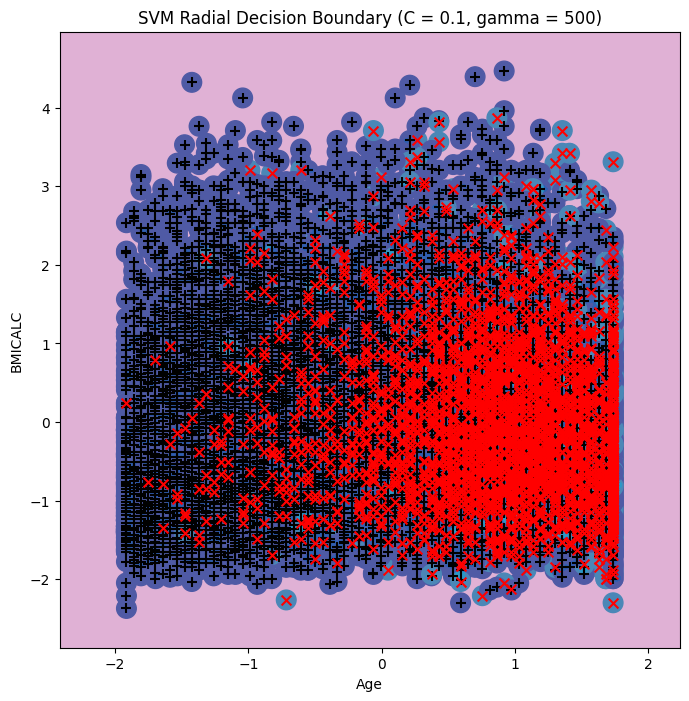

In [18]:
X_plot = data[['AGE', 'BMICALC']].values
y_plot = data[target].values

scaler = StandardScaler()
X_plot = scaler.fit_transform(X_plot)

svm_plot = SVC(C = grid_radial.best_params_['C'], gamma = grid_radial.best_params_['gamma'], kernel = 'rbf', random_state = 5322)
svm_plot.fit(X_plot, y_plot)

fig, ax = subplots(figsize = (8, 8))
plot_svm(X_plot, y_plot, svm_plot, ax = ax)
ax.set_xlabel('Age')
ax.set_ylabel('BMICALC')
ax.set_title(f'SVM Radial Decision Boundary (C = {grid_radial.best_params_["C"]}, gamma = {grid_radial.best_params_["gamma"]})')
plt.show()

Hard to see decision boundary for radial.

## Modeling - Polynomial SVM


Running poly SVM for Demo variables...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Params for Demo: {'C': 0.0001, 'coef0': 0, 'degree': 2, 'gamma': 0.0001}
Best CV Score for Demo: 0.816461202849334
              precision    recall  f1-score   support

   No Cancer       0.87      1.00      0.93      4159
      Cancer       0.00      0.00      0.00       630

    accuracy                           0.87      4789
   macro avg       0.43      0.50      0.46      4789
weighted avg       0.75      0.87      0.81      4789



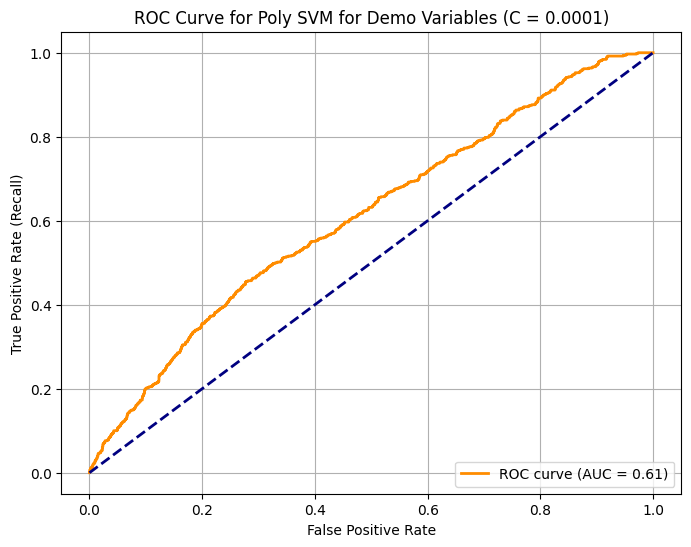


Running poly SVM for Habits variables...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Params for Habits: {'C': 0.001, 'coef0': 1, 'degree': 2, 'gamma': 0.1}
Best CV Score for Habits: 0.8175223708683093
              precision    recall  f1-score   support

   No Cancer       0.87      0.96      0.91      4159
      Cancer       0.17      0.06      0.08       630

    accuracy                           0.84      4789
   macro avg       0.52      0.51      0.50      4789
weighted avg       0.78      0.84      0.80      4789



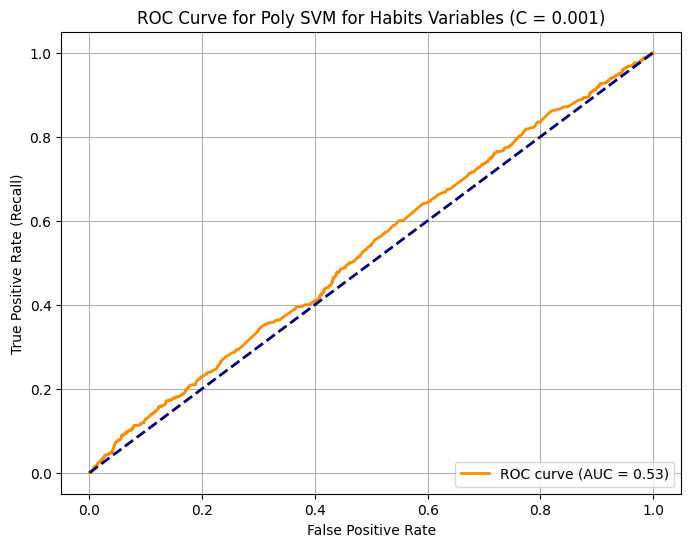

In [ ]:
param_poly = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'coef0': [0, 1],
    'degree': [2]
}

poly = SVC(kernel = 'poly', class_weight = 'balanced', random_state = 5322)

for name, (X, y) in groups.items():
    print(f'\nRunning poly SVM for {name} variables...')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 5322)
    
    grid_poly = GridSearchCV(
        estimator = poly,
        param_grid = param_poly,
        scoring = 'f1_weighted',
        cv = 3,
        n_jobs = -1,
        verbose = 1 
        # change verbose to 3 to see [CV 3/3] END ............................C=0.01;, score=0.700 total time=  11.5s
        # to check whether the grid search params are reasonable and changing the scores
    )
    
    grid_poly.fit(x_train, y_train)
    
    # get metrics
    print(f"Best Params for {name}: {grid_poly.best_params_}")
    print(f"Best CV Score for {name}: {grid_poly.best_score_}")
    print(classification_report(y_test, grid_poly.predict(x_test), zero_division = 0, target_names = ['No Cancer', 'Cancer']))
    
    y_scores = grid_poly.decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label = 2)
    roc_auc = auc(fpr, tpr)

    # plot roc curve
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for Poly SVM for {name} Variables (C = {grid_poly.best_params_["C"]})')
    plt.legend(loc = "lower right")
    plt.grid(True)
    plt.show()
    print('=' * 50)

Some things to note:

From the AUCs, demographic variables are more predictive of cancer than habit related ones\
Precision and recall are high for non-cancer individuals\
Precision and recall are low and non existent for cancer individuals\
Again, clear class imbalance: a lot more non-cancer individuals in our dataset versus cancer individuals

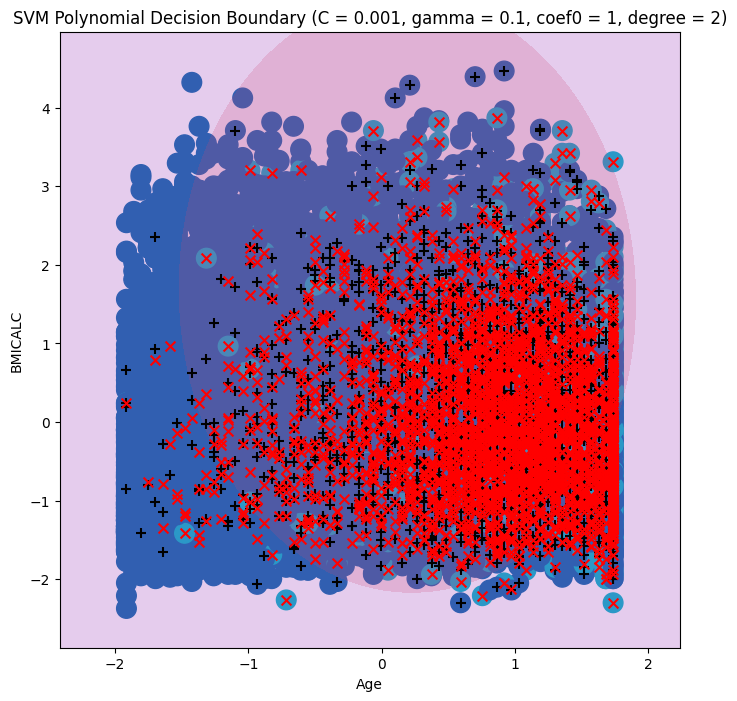

In [19]:
X_plot = data[['AGE', 'BMICALC']].values
y_plot = data[target].values

scaler = StandardScaler()
X_plot = scaler.fit_transform(X_plot)

svm_plot = SVC(C = grid_poly.best_params_['C'], gamma = grid_poly.best_params_['gamma'], coef0 = grid_poly.best_params_['coef0'], degree = grid_poly.best_params_['degree'], kernel = 'poly', random_state = 5322)
svm_plot.fit(X_plot, y_plot)

fig, ax = subplots(figsize = (8, 8))
plot_svm(X_plot, y_plot, svm_plot, ax = ax)
ax.set_xlabel('Age')
ax.set_ylabel('BMICALC')
ax.set_title(f'SVM Polynomial Decision Boundary (C = {grid_poly.best_params_["C"]}, gamma = {grid_poly.best_params_["gamma"]}, coef0 = {grid_poly.best_params_["coef0"]}, degree = {grid_poly.best_params_["degree"]})')
plt.show()

Cool oval shaped boundary. Pretty good

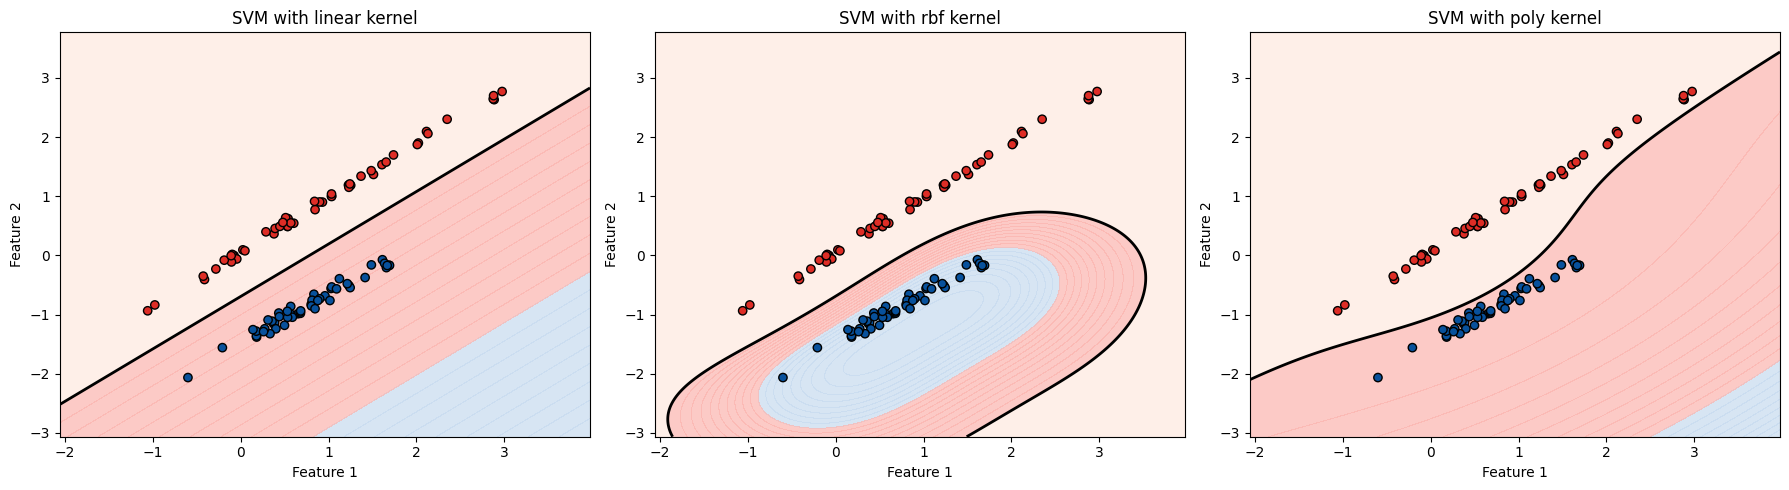

In [ ]:
# some basic svm plots for visualization
X, y = make_classification(
    n_samples = 100, n_features = 2, n_informative = 2, n_redundant = 0,
    n_clusters_per_class = 1, class_sep = 0.8, random_state = 42
)

xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500)
)

kernels = ['linear', 'rbf', 'poly']
models = [svm.SVC(kernel = k, degree = 3, C = 1).fit(X, y) for k in kernels]

background_cmap = ListedColormap(['#c6dbef', '#fbb4ae'])
point_cmap = ListedColormap(['#08519c', '#de2d26'])

plt.figure(figsize = (18, 5))

for i, (model, kernel) in enumerate(zip(models, kernels)):
    plt.subplot(1, 3, i + 1)

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), 0, 20), cmap = background_cmap, alpha = 0.7)
    plt.contourf(xx, yy, Z, levels = [0, Z.max()], colors = ['#fee0d2'], alpha = 0.5)
    plt.contour(xx, yy, Z, levels = [0], linewidths = 2, colors = 'k')

    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = point_cmap, edgecolors = 'k')
    plt.title(f"SVM with {kernel} kernel")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


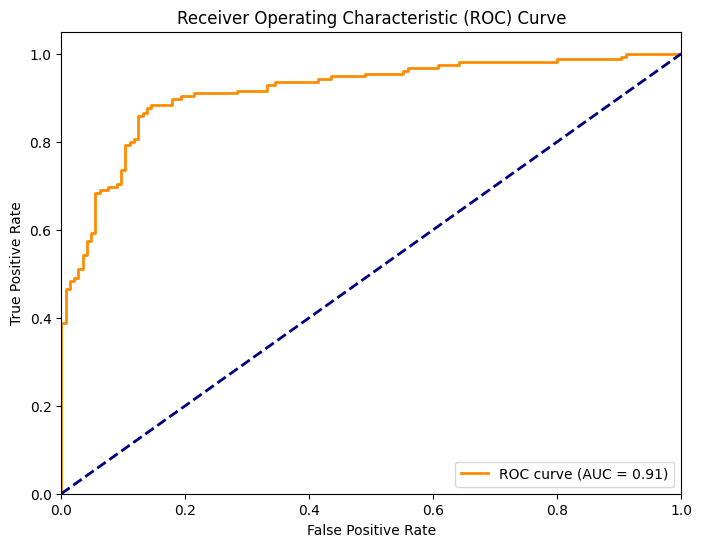

In [29]:
# create sample roc curve plot for example
X, y = make_classification(n_samples = 1000, n_features = 20, n_classes = 2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()